# Use bloomberg download data to get me started

In [221]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline

In [761]:
#initial cleaning function
def clean_sheet(dataframe):
    adj=dataframe.dropna(axis=1,how='all')
    adj=dataframe.set_index(adj.columns[0]) #use stock tickers as the index
    return adj

In [948]:
#pull the data from excel, form a dictionary of tab names and dataframes
tabs_to_grab=['Quarter','Date','Revision','Property']

data_dict={}

for s in tabs_to_grab:
    df=clean_sheet(pd.read_excel(r'C:\Users\Eric.Li\Documents\Post result data\Europe 2007-2018.xlsx',sheet_name=s))
    data_dict[s]=df.dropna(axis=0,how='all')

In [882]:
# get the price dataframe for certain years; form the price and return datetime from the data from all the years 
year_range=range(2007,2019)

price_list=[]
abs_return_list=[]
rel_return_list=[]
for year in year_range:
    price_year=clean_sheet(pd.read_excel(r'C:\Users\Eric.Li\Documents\Post result data\Europe price.xlsx',sheet_name=str(year))).dropna(how='all',axis=0)
    abs_return=price_year.diff(1,axis=1)/price_year.shift(1,axis=1)
    abs_return=abs_return.dropna(how='all',axis=0)
    rel_return=abs_return - abs_return.loc["SXXP Index"]
    rel_return=rel_return.dropna(how='all',axis=0)
    price_list.append(price_year)
    abs_return_list.append(abs_return)
    rel_return_list.append(rel_return)

price=pd.concat(price_list,axis=1).dropna(axis=1,how='all').dropna(axis=0,how='all')
abs_return=pd.concat(abs_return_list,axis=1).dropna(axis=1,how='all').dropna(axis=0,how='all')
rel_return=pd.concat(rel_return_list,axis=1).dropna(axis=1,how='all').dropna(axis=0,how='all')

# transform the datetime to the common timestamp format
price_column=[i.strftime("%d/%b/%Y") for i in price.columns.tolist() if type(i)!=str]
abs_return_column=[i.strftime("%d/%b/%Y") for i in abs_return.columns.tolist() if type(i)!=str]
rel_return_column=[i.strftime("%d/%b/%Y") for i in rel_return.columns.tolist() if type(i)!=str]

price.columns=price_column
abs_return.columns=abs_return_column
rel_return.columns=rel_return_column


In [887]:
# utility function to get volatility from return series
def vol_calc(return_series, vol_lookback):
    hist=len(return_series)
    if hist<=vol_lookback:
        vol=return_series[-hist+1:].std()
    else:
        vol=return_series[-period-1:-1].std()
    return vol

In [888]:
# utility function to obtain announcement return (as a multiplier of vol) as a result of day 0 and return dataframe
def ann_ret(single_date,return_series,EAR_period,vol_lookback):
    if type(single_date)==pd._libs.tslib.Timestamp:
        date_series=return_series.index.tolist()
        if single_date.strftime("%d/%b/%Y") in date_series:
            day0=date_series.index(single_date.strftime("%d/%b/%Y"))
            vol=vol_calc(return_series,vol_lookback)
            if len(return_series.iloc[day0:])<EAR_period:
                ret=return_series[day0:].sum()
                nmove=ret/vol
            else:
                ret=return_series.iloc[day0:day0+EAR_period].sum()
                nmove=ret/vol
            return nmove
        else:
            return None
    else:
        return single_date

In [916]:
# obtain the announcement return dataframe from price return and date dataframe
def EAR(date_df,return_df,EAR_period,vol_lookback):
    EAR_list=[]
    for ticker, date_row in date_df.iterrows():
        if type(ticker)==str: #deal with 
            return_row=return_df.loc[ticker]
            ret_series=date_row.apply(lambda x: ann_ret(x,return_row,EAR_period,vol_lookback))
            EAR_list.append(ret_series)
        else:
            pass
    EAR_df=pd.concat(EAR_list,axis=1).T
    return EAR_df

## Signal 1 - absolute signal

In [1028]:
#signal formation (number 1) and use the date as the base dataframe
def signal1_formation(date_df,return_df,EAR_period,vol_lookback,return_criteria,revision_df, revision_criteria):
    EAR_return=EAR(date_df,return_df,EAR_period,vol_lookback).fillna(0.0).loc[revision_df.index.tolist()]
    signal1_evaluate=(EAR_return>return_criteria) & (revision_df>revision_criteria)
    signal1=date_df[signal1_evaluate].dropna(axis=0,how='all').dropna(axis=1,how='all')
    return signal1

rel_signal1=signal1_formation(data_dict['Date'],abs_return,3,30,2,data_dict['Revision'],0.02)

In [1045]:
#Stack signals into a list of tuples (stocks, dates), convert dates into a common format of datetime
def signal1_stacking(signal1):
    signal1_list=[]
    for index, row in signal1.iterrows():
        adj_row=row.dropna()
        for s in adj_row.values:
            ts=(s - np.datetime64('1970-01-01T00:00:00Z')) / np.timedelta64(1, 's') 
            adj_time=datetime.utcfromtimestamp(ts).strftime("%d/%b/%Y") #transform the datetime into a common format
            signal1_list.append((adj_row.name,adj_time))
    return signal1_list

In [1046]:
# create a dictionary to have signal information (tuple) as keys and return data time series as values to make it easier to check
#; replace datetime with number of days post announcement to make it more comparable 
def signal1_return_dict(signal1_list,return_dataframe,holding):
    signal1_dict={}
    for s in signal1_list:
        return_series=return_dataframe.loc[s[0]]
        if s[1] in return_series.index:          
            day0=return_series.index.tolist().index(s[1]) #index of day 0
        else:
            pass
        target_series=return_series.iloc[day0:day0+min(holding, len(return_series[day0:]))]
        target_series.index=range(min(holding, len(return_series[day0:]))) #replace datetime with number of days post announcement
        target_series.name=s
        signal1_dict[s]=target_series
    return signal1_dict

In [1047]:
# obtain the dataframe of return time series for the signal stocks, take the signal_return_dict function
def signal1_return_df(signal1,return_dataframe,holding):
    return_series_list=[]
    return_dict=signal1_return_dict(signal1_stacking(signal1),return_dataframe,holding)
    for index,key in return_dict.items():
        return_series_list.append(key)
    return_df=pd.concat(return_series_list,axis=1)
    return_df=return_df.dropna(how='any',axis=1) #drop stocks with limited history to make it more comparable
    return return_df

rel_signal1_abs_return_df=signal1_return_df(rel_signal1,abs_return,130)
rel_signal1_rel_return_df=signal1_return_df(rel_signal1,rel_return,130)


C:\Users\Eric.Li\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  import sys


In [1049]:
# List of signals and cumulative returns
rel_signal1_ind_abs_return=rel_signal1_abs_return_df.iloc[3:].cumsum(axis=0).iloc[-1]
rel_signal1_ind_abs_return

rel_signal1_ind_rel_return=rel_signal1_rel_return_df.iloc[3:].cumsum(axis=0).iloc[-1]
rel_signal1_ind_rel_return.sort_values()

SWEDA SS   17/Jul/2008    -0.76948
TOM2 NA    24/Oct/2007   -0.723195
BKT SM     19/Jan/2012   -0.716197
BOL SS     19/Jul/2007     -0.7062
           08/May/2008   -0.658539
MHG NO     09/Feb/2011   -0.654099
YIT FH     25/Apr/2008   -0.652582
NOKIA FH   20/Oct/2011   -0.596503
SSABB SS   23/Jul/2014   -0.593165
OTE1V FH   23/Apr/2008   -0.589709
SSABA SS   23/Jul/2014    -0.58081
NRE1V FH   07/May/2008   -0.559881
YAR NO     18/Apr/2008   -0.551237
KCO GR     01/Apr/2008   -0.526482
UG FP      23/Jul/2008   -0.513388
KBC BB     12/May/2011    -0.50459
AF FP      18/Feb/2016   -0.483105
ELUXB SS   17/Jul/2007   -0.480958
DBK GR     30/Jul/2015   -0.475466
NHY NO     22/Apr/2008   -0.463499
MTGB SS    22/Jul/2008   -0.458993
SCYR SM    30/Jul/2009   -0.452369
NHY NO     11/Feb/2015   -0.450458
CLN SW     06/May/2011   -0.444035
IFX GR     30/Apr/2008   -0.432385
EBS AV     30/Apr/2008   -0.426701
MTGB SS    22/Apr/2008   -0.420582
BOKA NA    21/Aug/2008   -0.405629
SSABA SS   27/Apr/20

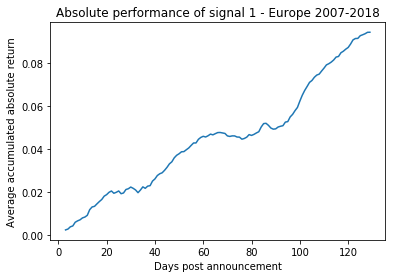

In [1050]:
# Performance analytics
# 1. aggregate abs/rel performance over time
def perf_chart(return_df,xlabel,ylabel,title):
    cum_return=return_df.mean(axis=1).cumsum()
    plt.plot(cum_return)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()
    
perf_chart(abs_signal1_abs_return_df.iloc[3:], xlabel="Days post announcement",
           ylabel="Average accumulated absolute return",title="Absolute performance of signal 1 - Europe 2007-2018")

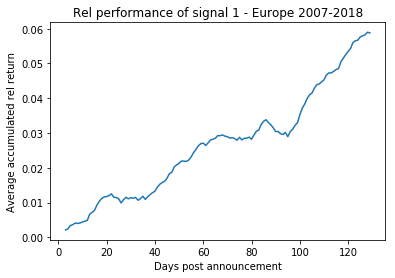

In [1051]:
perf_chart(abs_signal1_rel_return_df.iloc[3:], xlabel="Days post announcement",
           ylabel="Average accumulated rel return",title="Rel performance of signal 1 - Europe 2007-2018")


In [1052]:
# 2. trading analytics
def trading_analytics(return_df):
    ind_return=return_df.cumsum(axis=0).iloc[-1]
    signal1_count=len(ind_return)
    hit_rate=len(ind_return[ind_return>0])/len(ind_return)*1.0
    payoff_ratio=ind_return[ind_return>0].mean()/ind_return[ind_return<0].mean()*-1.0
    #annualised_return=return_df.mean(axis=1).cumsum().iloc[-1]*260/(len(return_df))
    #annualised_vol=return_df.mean(axis=1).std()*((260/(len(return_df)))**0.5)
    #annualised_sharpe=annualised_return/annualised_vol*1.0
    return signal1_count, hit_rate,payoff_ratio
    
trading_analytics(abs_signal1_rel_return_df[3:]) 


(554, 0.6498194945848376, 1.3600545261759656)

C:\Users\Eric.Li\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  import sys


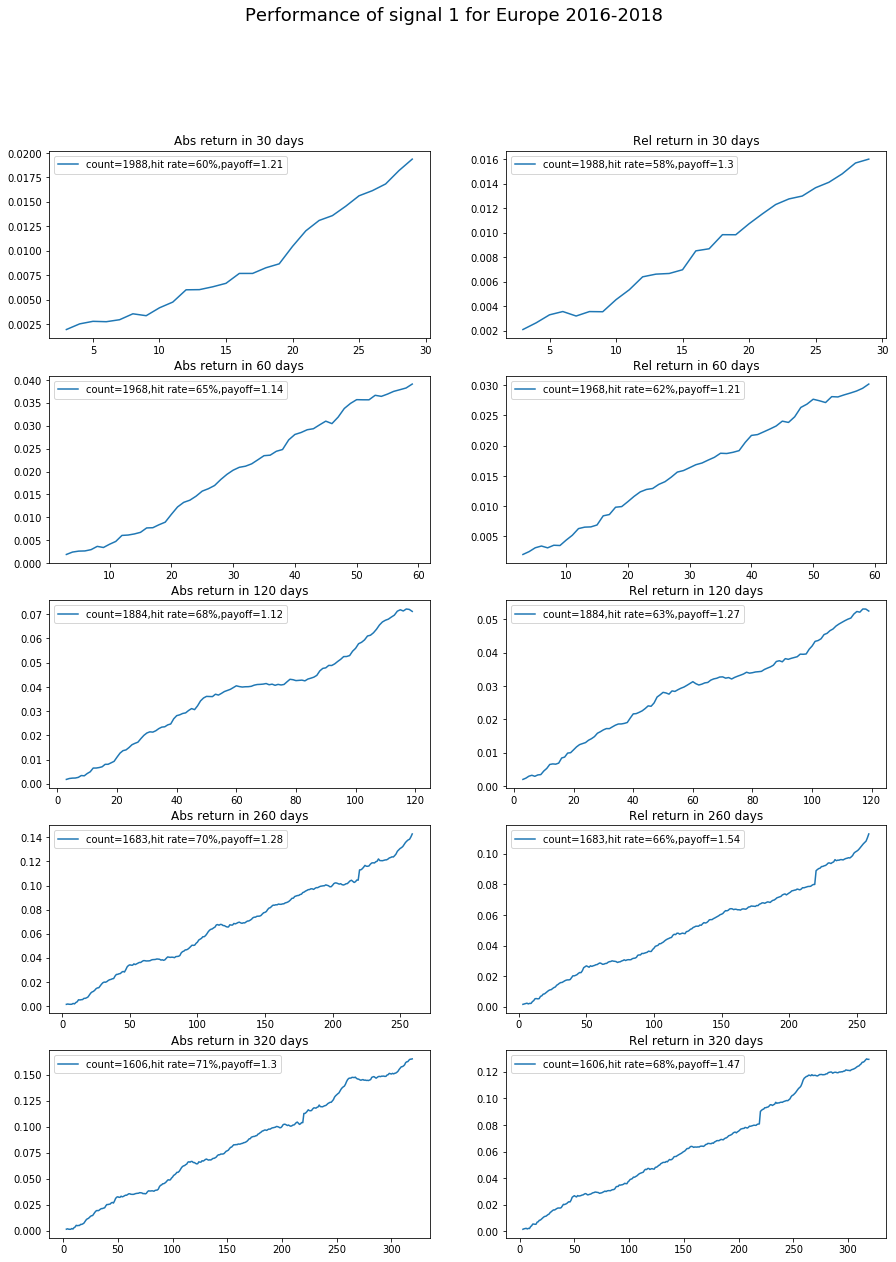

In [1053]:
# plot the performance for different holding period 
def multiple_plot(period_list,figsize,fontsize,title,signal1_list,abs_return,rel_return):    
    #period_list=[30,60,120,260]
    fig=plt.figure(figsize=figsize)
    fig.suptitle("Performance of signal 1 for Europe 2016-2018", fontsize=fontsize)
    for idx, val in enumerate(period_list):
        ax1=fig.add_subplot(len(period_list),2,idx*2+1)
        abs_return_df=signal1_return_df(signal1_list,abs_return,val)
        abs_cum_return=abs_return_df[3:].mean(axis=1).cumsum()
        ax1.plot(abs_cum_return)
        ax1.set_title("Abs return in "+str(val)+" days")
        count,hit, payoff=trading_analytics(abs_return_df[3:])
        ax1.legend(['count='+str(count)+
                    ',hit rate='+str("{:.0%}".format(hit))+
                    ',payoff='+str(round(payoff,2))])

        ax2=fig.add_subplot(len(period_list),2,idx*2+2)
        rel_return_df=signal1_return_df(signal1_list,rel_return,val)
        rel_cum_return=rel_return_df[3:].mean(axis=1).cumsum()
        ax2.plot(rel_cum_return)
        ax2.set_title("Rel return in "+str(val)+" days")
        count,hit, payoff=trading_analytics(rel_return_df[3:])
        ax2.legend(['count='+str(count)+
                    ',hit rate='+str("{:.0%}".format(hit))+
                    ',payoff='+str(round(payoff,2))])
    plt.show()

    
multiple_plot([30,60,120,260,320],(15,20),18,"Performance of signal 1 for Europe 2016-2018",rel_signal1,abs_return,rel_return)